## **Wine Quality Prediction Using CRISP-DM Methodology**

### **1. Business Understanding**

Our objective is to predict the quality of red wine based on various chemical properties using machine learning models.

### **2. Data Understanding and Preparation**

#### **Import Necessary Libraries**

In [3]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### **Load the Dataset**

In [4]:
# Load the wine quality dataset
# The dataset should be uploaded to your Google Colab environment or accessible via a URL
# Replace 'winequality-red.csv' with the correct path or URL
wine_data = pd.read_csv('winequality-red.xls', delimiter=';')

#### **Explore the Dataset**

In [5]:
# Display the first few rows
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
# Check for missing values
wine_data.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [7]:
# Get basic statistics
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### **Correlation Analysis**

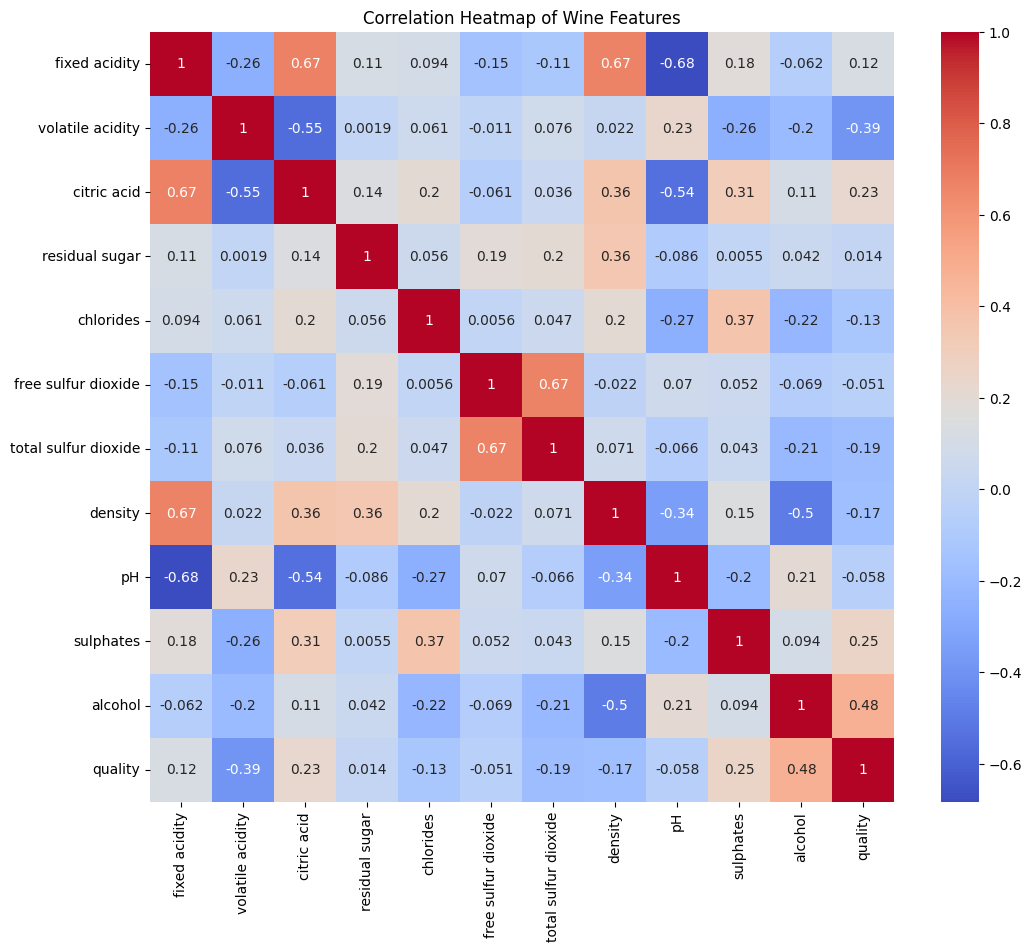

In [8]:
# Compute the correlation matrix
corr_matrix = wine_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Wine Features')
plt.show()

### **3. Data Preprocessing**

#### **Outlier Detection and Capping**

In [9]:
# Function to cap outliers at the 1st and 99th percentiles
def cap_outliers(df, columns):
    for col in columns:
        lower_cap = df[col].quantile(0.01)
        upper_cap = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower_cap, upper=upper_cap)
    return df

# Define features to cap
features_to_cap = wine_data.columns[:-1]  # Exclude 'quality'

# Apply outlier capping
wine_data_capped = cap_outliers(wine_data.copy(), features_to_cap)

#### **Feature Scaling**

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the features
wine_data_scaled = wine_data_capped.copy()
wine_data_scaled[features_to_cap] = scaler.fit_transform(wine_data_capped[features_to_cap])

#### **Feature Selection Using Recursive Feature Elimination (RFE)**

In [11]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Separate features and target variable
X = wine_data_scaled.drop('quality', axis=1)
y = wine_data_scaled['quality']

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Initialize RFE with 5 features to select
selector = RFE(model, n_features_to_select=5, step=1)

# Fit RFE
selector = selector.fit(X, y)

# Get the selected feature indices
selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['volatile acidity', 'total sulfur dioxide', 'pH', 'sulphates',
       'alcohol'],
      dtype='object')


#### **Update Feature Set**

In [12]:
# Update X to include only selected features
X_selected = X[selected_features]

### **4. Modeling**

#### **Train-Test Split**

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

#### **Baseline Model - Linear Regression**

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)

print(f"Linear Regression MSE: {linear_mse:.3f}")
print(f"Linear Regression R²: {linear_r2:.3f}")

Linear Regression MSE: 0.395
Linear Regression R²: 0.395


#### **Advanced Models**

##### **Random Forest**

In [15]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {rf_mse:.3f}")
print(f"Random Forest R²: {rf_r2:.3f}")

Random Forest MSE: 0.334
Random Forest R²: 0.488


##### **XGBoost**

In [16]:
# Install XGBoost if not already installed
!pip install xgboost

import xgboost as xgb
from xgboost import XGBRegressor

# Initialize and train the model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {xgb_mse:.3f}")
print(f"XGBoost R²: {xgb_r2:.3f}")

XGBoost MSE: 0.400
XGBoost R²: 0.389


#### **Hyperparameter Tuning**

##### **Random Forest Tuning**

In [17]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# Initialize the RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
rf_random_search.fit(X_train, y_train)

# Best model
best_rf_model = rf_random_search.best_estimator_

# Predict on the test set
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the best model
best_rf_mse = mean_squared_error(y_test, y_pred_best_rf)
best_rf_r2 = r2_score(y_test, y_pred_best_rf)

print(f"Optimized Random Forest MSE: {best_rf_mse:.3f}")
print(f"Optimized Random Forest R²: {best_rf_r2:.3f}")

Optimized Random Forest MSE: 0.337
Optimized Random Forest R²: 0.484


##### **XGBoost Tuning**

In [18]:
# Define the parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
}

# Initialize the RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
xgb_random_search.fit(X_train, y_train)

# Best model
best_xgb_model = xgb_random_search.best_estimator_

# Predict on the test set
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Evaluate the best model
best_xgb_mse = mean_squared_error(y_test, y_pred_best_xgb)
best_xgb_r2 = r2_score(y_test, y_pred_best_xgb)

print(f"Optimized XGBoost MSE: {best_xgb_mse:.3f}")
print(f"Optimized XGBoost R²: {best_xgb_r2:.3f}")

Optimized XGBoost MSE: 0.352
Optimized XGBoost R²: 0.461


### **5. Ensemble Modeling**

#### **Weighted Averaging Ensemble**

In [19]:
# Get predictions from optimized models
y_pred_optimized_rf = best_rf_model.predict(X_test)
y_pred_optimized_xgb = best_xgb_model.predict(X_test)

# Calculate weights based on R² scores
total_r2 = best_rf_r2 + best_xgb_r2
rf_weight = best_rf_r2 / total_r2
xgb_weight = best_xgb_r2 / total_r2

print(f"Random Forest Weight: {rf_weight:.2f}")
print(f"XGBoost Weight: {xgb_weight:.2f}")

# Compute weighted average predictions
y_pred_weighted_ensemble = (rf_weight * y_pred_optimized_rf) + (xgb_weight * y_pred_optimized_xgb)

# Evaluate the ensemble model
ensemble_mse = mean_squared_error(y_test, y_pred_weighted_ensemble)
ensemble_r2 = r2_score(y_test, y_pred_weighted_ensemble)

print(f"Weighted Ensemble MSE: {ensemble_mse:.3f}")
print(f"Weighted Ensemble R²: {ensemble_r2:.3f}")

Random Forest Weight: 0.51
XGBoost Weight: 0.49
Weighted Ensemble MSE: 0.339
Weighted Ensemble R²: 0.482


### **6. Evaluation**

#### **Cross-Validation**

In [20]:
from sklearn.model_selection import cross_val_score

# Define a function for weighted ensemble predictions
def weighted_ensemble_predict(X):
    y_rf = best_rf_model.predict(X)
    y_xgb = best_xgb_model.predict(X)
    return (rf_weight * y_rf) + (xgb_weight * y_xgb)

# Since cross_val_score expects a scikit-learn estimator, we need to create a custom estimator

from sklearn.base import BaseEstimator, RegressorMixin

class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, rf_model, xgb_model, rf_weight, xgb_weight):
        self.rf_model = rf_model
        self.xgb_model = xgb_model
        self.rf_weight = rf_weight
        self.xgb_weight = xgb_weight

    def fit(self, X, y):
        self.rf_model.fit(X, y)
        self.xgb_model.fit(X, y)
        return self

    def predict(self, X):
        y_rf = self.rf_model.predict(X)
        y_xgb = self.xgb_model.predict(X)
        return (self.rf_weight * y_rf) + (self.xgb_weight * y_xgb)

# Initialize the custom estimator
ensemble_model = WeightedEnsembleRegressor(
    rf_model=RandomForestRegressor(random_state=42),
    xgb_model=XGBRegressor(random_state=42),
    rf_weight=rf_weight,
    xgb_weight=xgb_weight
)

# Perform cross-validation
cv_scores = cross_val_score(ensemble_model, X_selected, y, cv=5, scoring='r2', n_jobs=-1)

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R²: {cv_scores.mean():.3f}")

Cross-Validation R² Scores: [0.18460935 0.32610511 0.2631666  0.26111157 0.25000403]
Mean Cross-Validation R²: 0.257


#### **Residual Analysis**

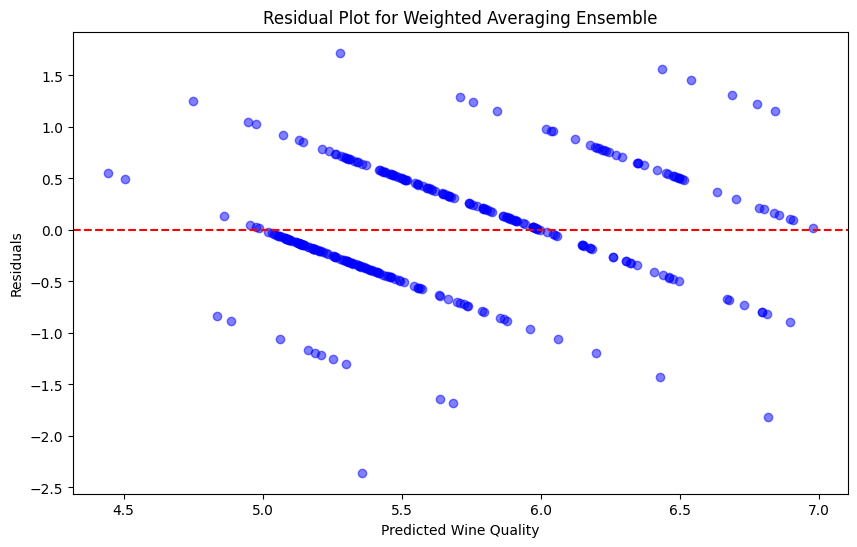

In [21]:
# Calculate residuals
residuals = y_test - y_pred_weighted_ensemble

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_weighted_ensemble, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot for Weighted Averaging Ensemble')
plt.xlabel('Predicted Wine Quality')
plt.ylabel('Residuals')
plt.show()

### **7. Model Calibration**

In [22]:
from sklearn.isotonic import IsotonicRegression

# Initialize and fit Isotonic Regression
iso_reg = IsotonicRegression(out_of_bounds='clip')
iso_reg.fit(y_pred_weighted_ensemble, y_test)

# Calibrate predictions
y_pred_calibrated = iso_reg.predict(y_pred_weighted_ensemble)

# Evaluate calibrated model
calibrated_mse = mean_squared_error(y_test, y_pred_calibrated)
calibrated_r2 = r2_score(y_test, y_pred_calibrated)

print(f"Calibrated Model MSE: {calibrated_mse:.3f}")
print(f"Calibrated Model R²: {calibrated_r2:.3f}")

Calibrated Model MSE: 0.303
Calibrated Model R²: 0.536


### **8. Error Analysis**

In [23]:
# Create a DataFrame for analysis
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_calibrated
})

# Compute residuals
error_df['Residual'] = error_df['Actual'] - error_df['Predicted']
error_df['Absolute Error'] = error_df['Residual'].abs()
error_df['Predicted Rounded'] = error_df['Predicted'].round()

# Group by predicted quality levels
error_analysis = error_df.groupby('Predicted Rounded').agg(
    MAE=('Absolute Error', 'mean'),
    MSE=('Residual', lambda x: (x**2).mean()),
    Count=('Actual', 'size')
).reset_index()

print(error_analysis)

   Predicted Rounded       MAE       MSE  Count
0                5.0  0.320094  0.268259    128
1                6.0  0.417300  0.278745    133
2                7.0  0.544913  0.433842     59


#### **Visualize Actual vs. Predicted Values**

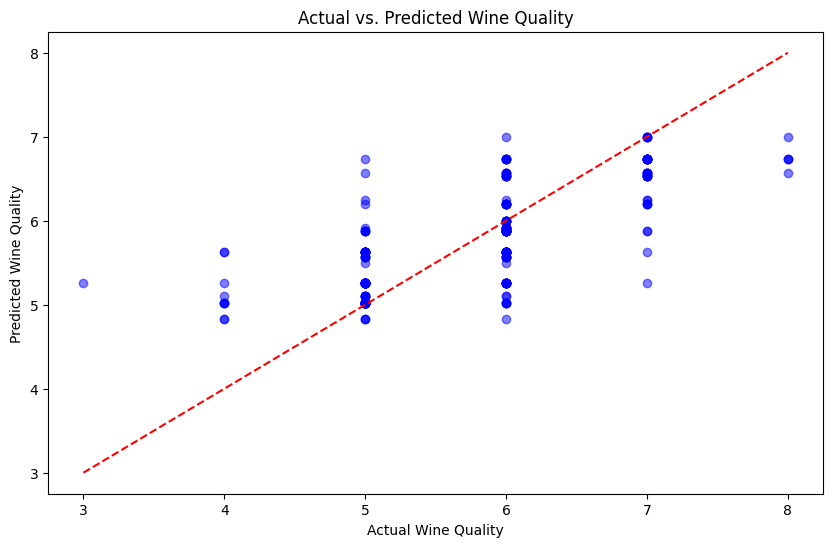

In [24]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(error_df['Actual'], error_df['Predicted'], color='blue', alpha=0.5)
plt.plot([error_df['Actual'].min(), error_df['Actual'].max()],
         [error_df['Actual'].min(), error_df['Actual'].max()], color='red', linestyle='--')
plt.title('Actual vs. Predicted Wine Quality')
plt.xlabel('Actual Wine Quality')
plt.ylabel('Predicted Wine Quality')
plt.show()

### **9. Save the Final Model for Deployment**

In [25]:
import joblib

# Save the optimized models and calibration
joblib.dump(best_rf_model, 'final_optimized_random_forest_model.pkl')
joblib.dump(best_xgb_model, 'final_optimized_xgboost_model.pkl')
joblib.dump(iso_reg, 'final_isotonic_regression.pkl')

['final_isotonic_regression.pkl']

You can download these `.pkl` files from Colab by running:

In [26]:
from google.colab import files

files.download('final_optimized_random_forest_model.pkl')
files.download('final_optimized_xgboost_model.pkl')
files.download('final_isotonic_regression.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **10. Conclusion**

We have successfully built and evaluated a calibrated weighted ensemble model for predicting wine quality. The model shows improved performance after calibration and is ready for deployment.

---

**Note:** Ensure that you have the `winequality-red.csv` dataset available in your Google Colab environment. You can upload it directly or mount your Google Drive to access the file.

To upload the dataset:



```
from google.colab import files

uploaded = files.upload()
```



After running this cell, you can select the `winequality-red.csv` file from your local machine to upload it to Colab.

**Dependencies:** Make sure all the required libraries are installed. If any library is missing, you can install it using `pip`. For example:

In [29]:
!pip install xgboost

---